此篇程式參考來源：https://github.com/Soumi7/Table_Data_Extraction \
作者：Soumi Bardhan \
查詢日期：2023.03.04

In [1]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import statistics
import requests
import pandas as pd
import re

In [2]:
fileImg = './Data/Y3027770.png'
# fileImg = './Data/Y3027770L.png'

print('fileImg= ', fileImg)

fileImg=  ./Data/Y3027770.png


basename=  Y3027770.png
filename=  Y3027770


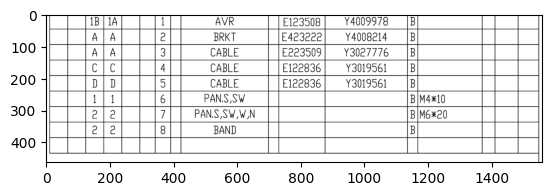

In [3]:
basename = os.path.basename(fileImg)
print('basename= ', basename)
filename = os.path.splitext(basename)[0]
print('filename= ', filename)

# cv2.imread() 載入圖片，參數"0" 轉為灰階
img = cv2.imread(fileImg, 0)
plot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

threshImg=  106.0


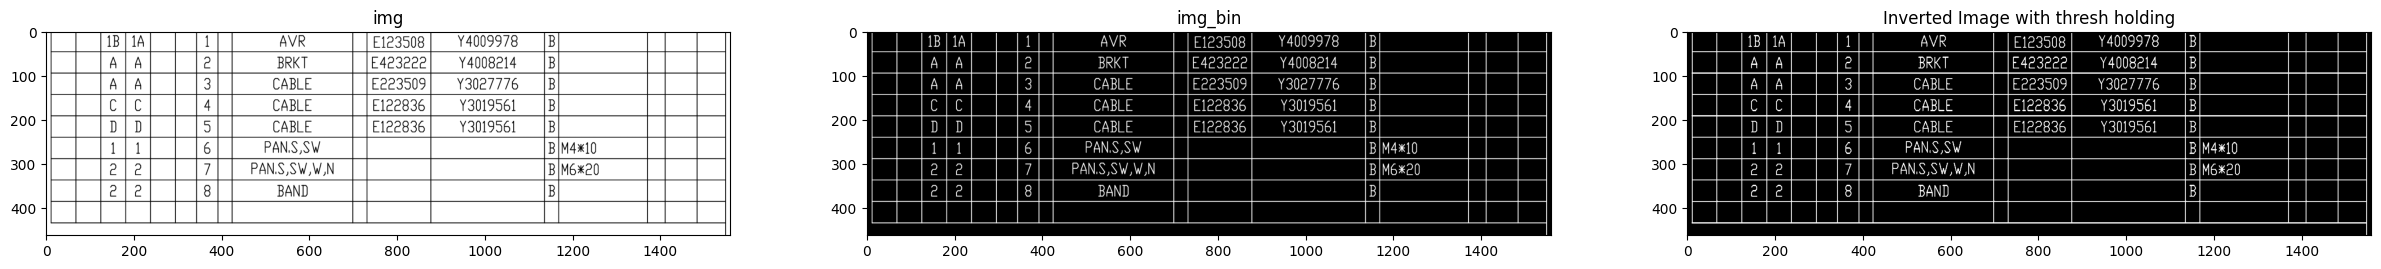

In [4]:
# plt.figure() 顯示的圖像指定尺寸為"30*30"
plt.figure(figsize= (30, 30))

# 灰階色彩反轉
# plt.subplot() 以1列3行顯示圖像，第1個圖像顯示內容如下，plt.imshow(img, cmap='gray')顯示圖面，cmap='gray'以灰度圖呈現
plt.subplot(131), plt.imshow(img, cmap='gray')
plt.title('img')

# 將img的灰階色彩反轉
img_bin = 255 - img
plt.subplot(132), plt.imshow(img_bin, cmap='gray')
plt.title('img_bin')

# cv2.threshold() 將圖像二值化(黑或白)，二值化閾值可使用"BINARY" 或"OSTU"
# 等號左邊的threshImg 輸出判定閾值
# cv2.THRESH_BINARY(二分法) 需指定閾值界線，低於界線的值變為0，高於界線的值變為255(最大值)
# cv2.THRESH_OTSU(otsu) 自動閾值區分，演算法會抓去最適當的閾值
threshImg, img_bin_otsu = cv2.threshold(img_bin, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print('threshImg= ', threshImg)
plotting = plt.subplot(133), plt.imshow(cv2.cvtColor(img_bin_otsu, cv2.COLOR_BGR2RGB))
# plt.title('影像灰階反轉後使用otsu二值化的結果')
# plt.title('Inverted Image with otsu thresh holding')
# plt.title('img二值化後將RGB倒置處理(cv2讀取的影像在matplotlib中色彩有倒置的問題)')
plt.title('Inverted Image with thresh holding')
plt.show()

In [5]:
# cv2.getStructuringElement() 建立結構矩陣，矩陣內每個值皆為1
# 矩陣形式為(column(列), row(行))
# cv2.MORPH_RECT 矩陣形式為矩形，cv2.MORPH_CROSS 矩陣形式為十字，cv2.MORPH_ELLIPSE 矩陣形式為橢圓
ver_hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
print('ver_hor_kernel= \n', ver_hor_kernel)

ver_hor_kernel= 
 [[1 1]
 [1 1]]


img_height 463
height_rate=  50
height_iter=  10


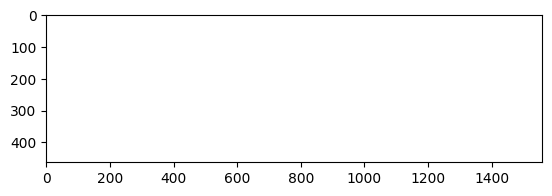

In [6]:
# opencv紀錄圖像的格視為H(高度)*W(寬度)*C(通道數)，通道數指RGB3色域
# 提取圖像高度及寬度並記錄
img_height = img.shape[0]
print('img_height', img_height)
img_wedth = img.shape[1]
# 設定圖像在不同高度時會有不同的遮罩縮放比例，避免圖像高度較小的時候會有遮罩被吃掉的問題
if img_height>=200:
    height_rate = 50
    height_iter = 10
elif 100<img_height<=200:
    height_rate = 100
    height_iter = 10
else:
    height_rate = 10
    height_iter = 5
print('height_rate= ', height_rate)
print('height_iter= ', height_iter)

# 建立與原圖像等尺寸的全白圖片，後續驗證boxes_list用
blank = (img_height, img_wedth, 3)
blank_img = np.full(blank, 255).astype(np.uint8)
plt.imshow(blank_img)

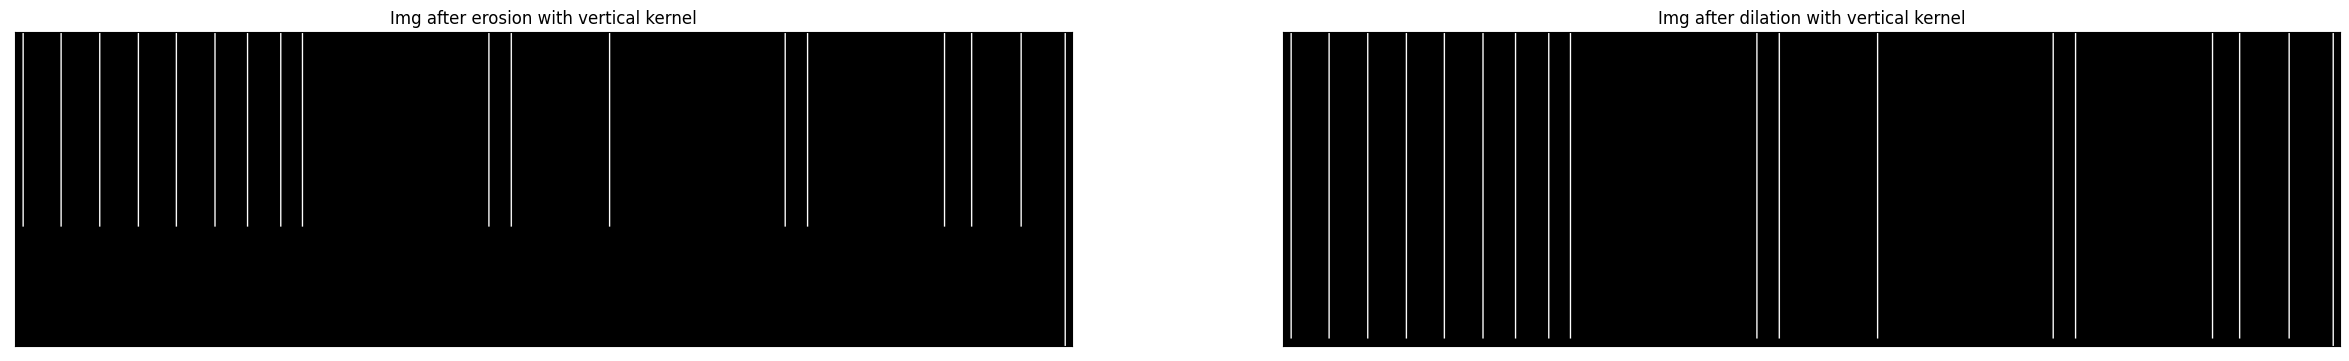

In [7]:
plt.figure(figsize= (30, 30))

# 處理影像並拆分出需要的垂直線vertical
# 建立1個矩陣尺寸為 "1* np.array(img).shape[1]//100" (np.array(img).shape[1]指建立1個符合img圖像全尺寸的陣列，//指結果取整數)
# ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img).shape[1]//100))
# 建立1個矩陣尺寸為 "1* np.array(img).shape[1]//height_rate" 改用圖像高度判斷遮罩大小
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img).shape[1]//height_rate))
# print('ver_kernel= \n', ver_kernel)
# cv2.erode() 侵蝕遮罩，使用ver_kernel作為遮罩，iterations=3 執行3次
# 侵蝕的時候圖像會以ver_kernel作為遮罩，遮罩中最上及最下端會侵蝕為0
# 侵蝕的時候遮罩範圍內8近鄰的最外層會侵蝕為0
# vertical_eroded_img = cv2.erode(img_bin_otsu, ver_kernel, iterations=3)
vertical_eroded_img = cv2.erode(img_bin_otsu, ver_kernel, iterations=height_iter)
# print('vertical_eroded_img= \n', vertical_eroded_img)
plt.subplot(121), plt.imshow(vertical_eroded_img, cmap='gray')
# plt.title('Img受到vertical kernel侵蝕後的圖像'), plt.xticks([]), plt.yticks([])
# plt.xticks([]) x座標內容顯示為空白，plt.yticks([]) y座標內容顯示為空白
plt.title('Img after erosion with vertical kernel'), plt.xticks([]), plt.yticks([])

# cv2.dilate() 膨脹遮罩，使用ver_kernel作為遮罩，iterations=3 執行3次
# 膨脹時圖像會以ver_kernel作為遮罩，遮罩中最上及最下端會膨脹為1
# 膨脹時遮罩範圍外側8近鄰位置的值膨脹為1
# vertical_dilate_lines = cv2.dilate(vertical_eroded_img, ver_kernel, iterations=3)
vertical_dilate_lines = cv2.dilate(vertical_eroded_img, ver_kernel, iterations=height_iter+1)
# print('vertical_dilate_lines= \n', vertical_dilate_lines)
plt.subplot(122), plt.imshow(cv2.cvtColor(vertical_dilate_lines, cv2.COLOR_BGR2RGB))
# plt.title('vertical_eroded_img受到vertical kernel膨脹後的圖像'), plt.xticks([]), plt.yticks([])
plt.title('Img after dilation with vertical kernel'), plt.xticks([]), plt.yticks([])

vertical_lines = vertical_dilate_lines
plt.show()

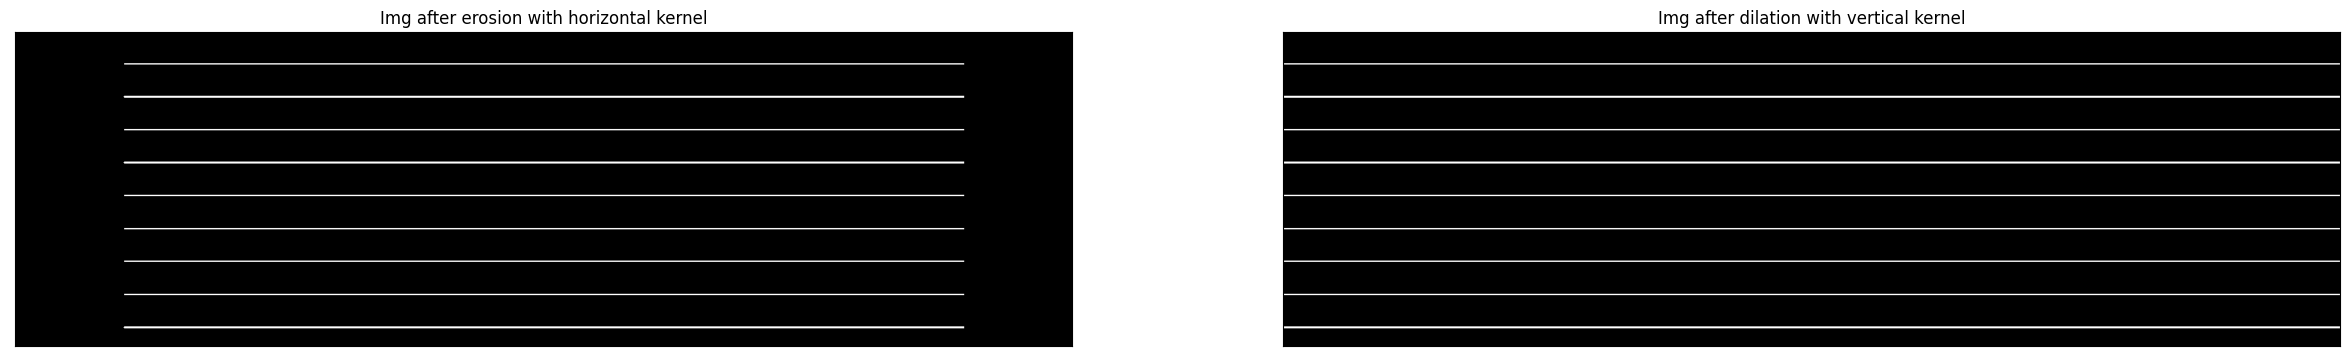

In [8]:
plt.figure(figsize=(30, 30))

# 處理影像並拆分出需要的水平線horizontal
# 建立1個矩陣尺寸為 "np.array(img).shape[1]//100, 1"
# hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//100, 1))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//50, 1))
# print('hor_kernel= \n', hor_kernel)
# cv2.erode() 侵蝕遮罩，使用hor_kernel作為遮罩，iterations=3 執行3次
# horizontal_erode_lines = cv2.erode(img_bin_otsu, hor_kernel, iterations=3)
horizontal_erode_lines = cv2.erode(img_bin_otsu, hor_kernel, iterations=10)
# print('horizontal_erode_lines= \n', horizontal_erode_lines)
plt.subplot(121), plt.imshow(horizontal_erode_lines, cmap='gray')
# plt.title('Img受到horizontal kernel侵蝕後的圖像'), plt.xticks([]), plt.yticks([])
plt.title('Img after erosion with horizontal kernel'), plt.xticks([]), plt.yticks([])

# cv2.dilate() 膨脹遮罩，使用hor_kernel作為遮罩，iterations=3 執行3次
# horizontal_dilate_lines = cv2.dilate(horizontal_erode_lines, hor_kernel, iterations=3)
horizontal_dilate_lines = cv2.dilate(horizontal_erode_lines, hor_kernel, iterations=11)
# print('horizontal_dilate_lines= \n', horizontal_dilate_lines)
plt.subplot(122), plt.imshow(cv2.cvtColor(horizontal_dilate_lines, cv2.COLOR_BGR2RGB))
# plt.title('Img受到horizontal kernel膨脹後的圖像'), plt.xticks([]), plt.yticks([])
plt.title('Img after dilation with vertical kernel'), plt.xticks([]), plt.yticks([])

horizontal_lines = horizontal_dilate_lines
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_15980\3910237340.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(321), plt.imshow(cv2.cvtColor(vertical_horizontal_lines, cv2.COLOR_BGR2RGB))


thresh_ver_hor=  127.0


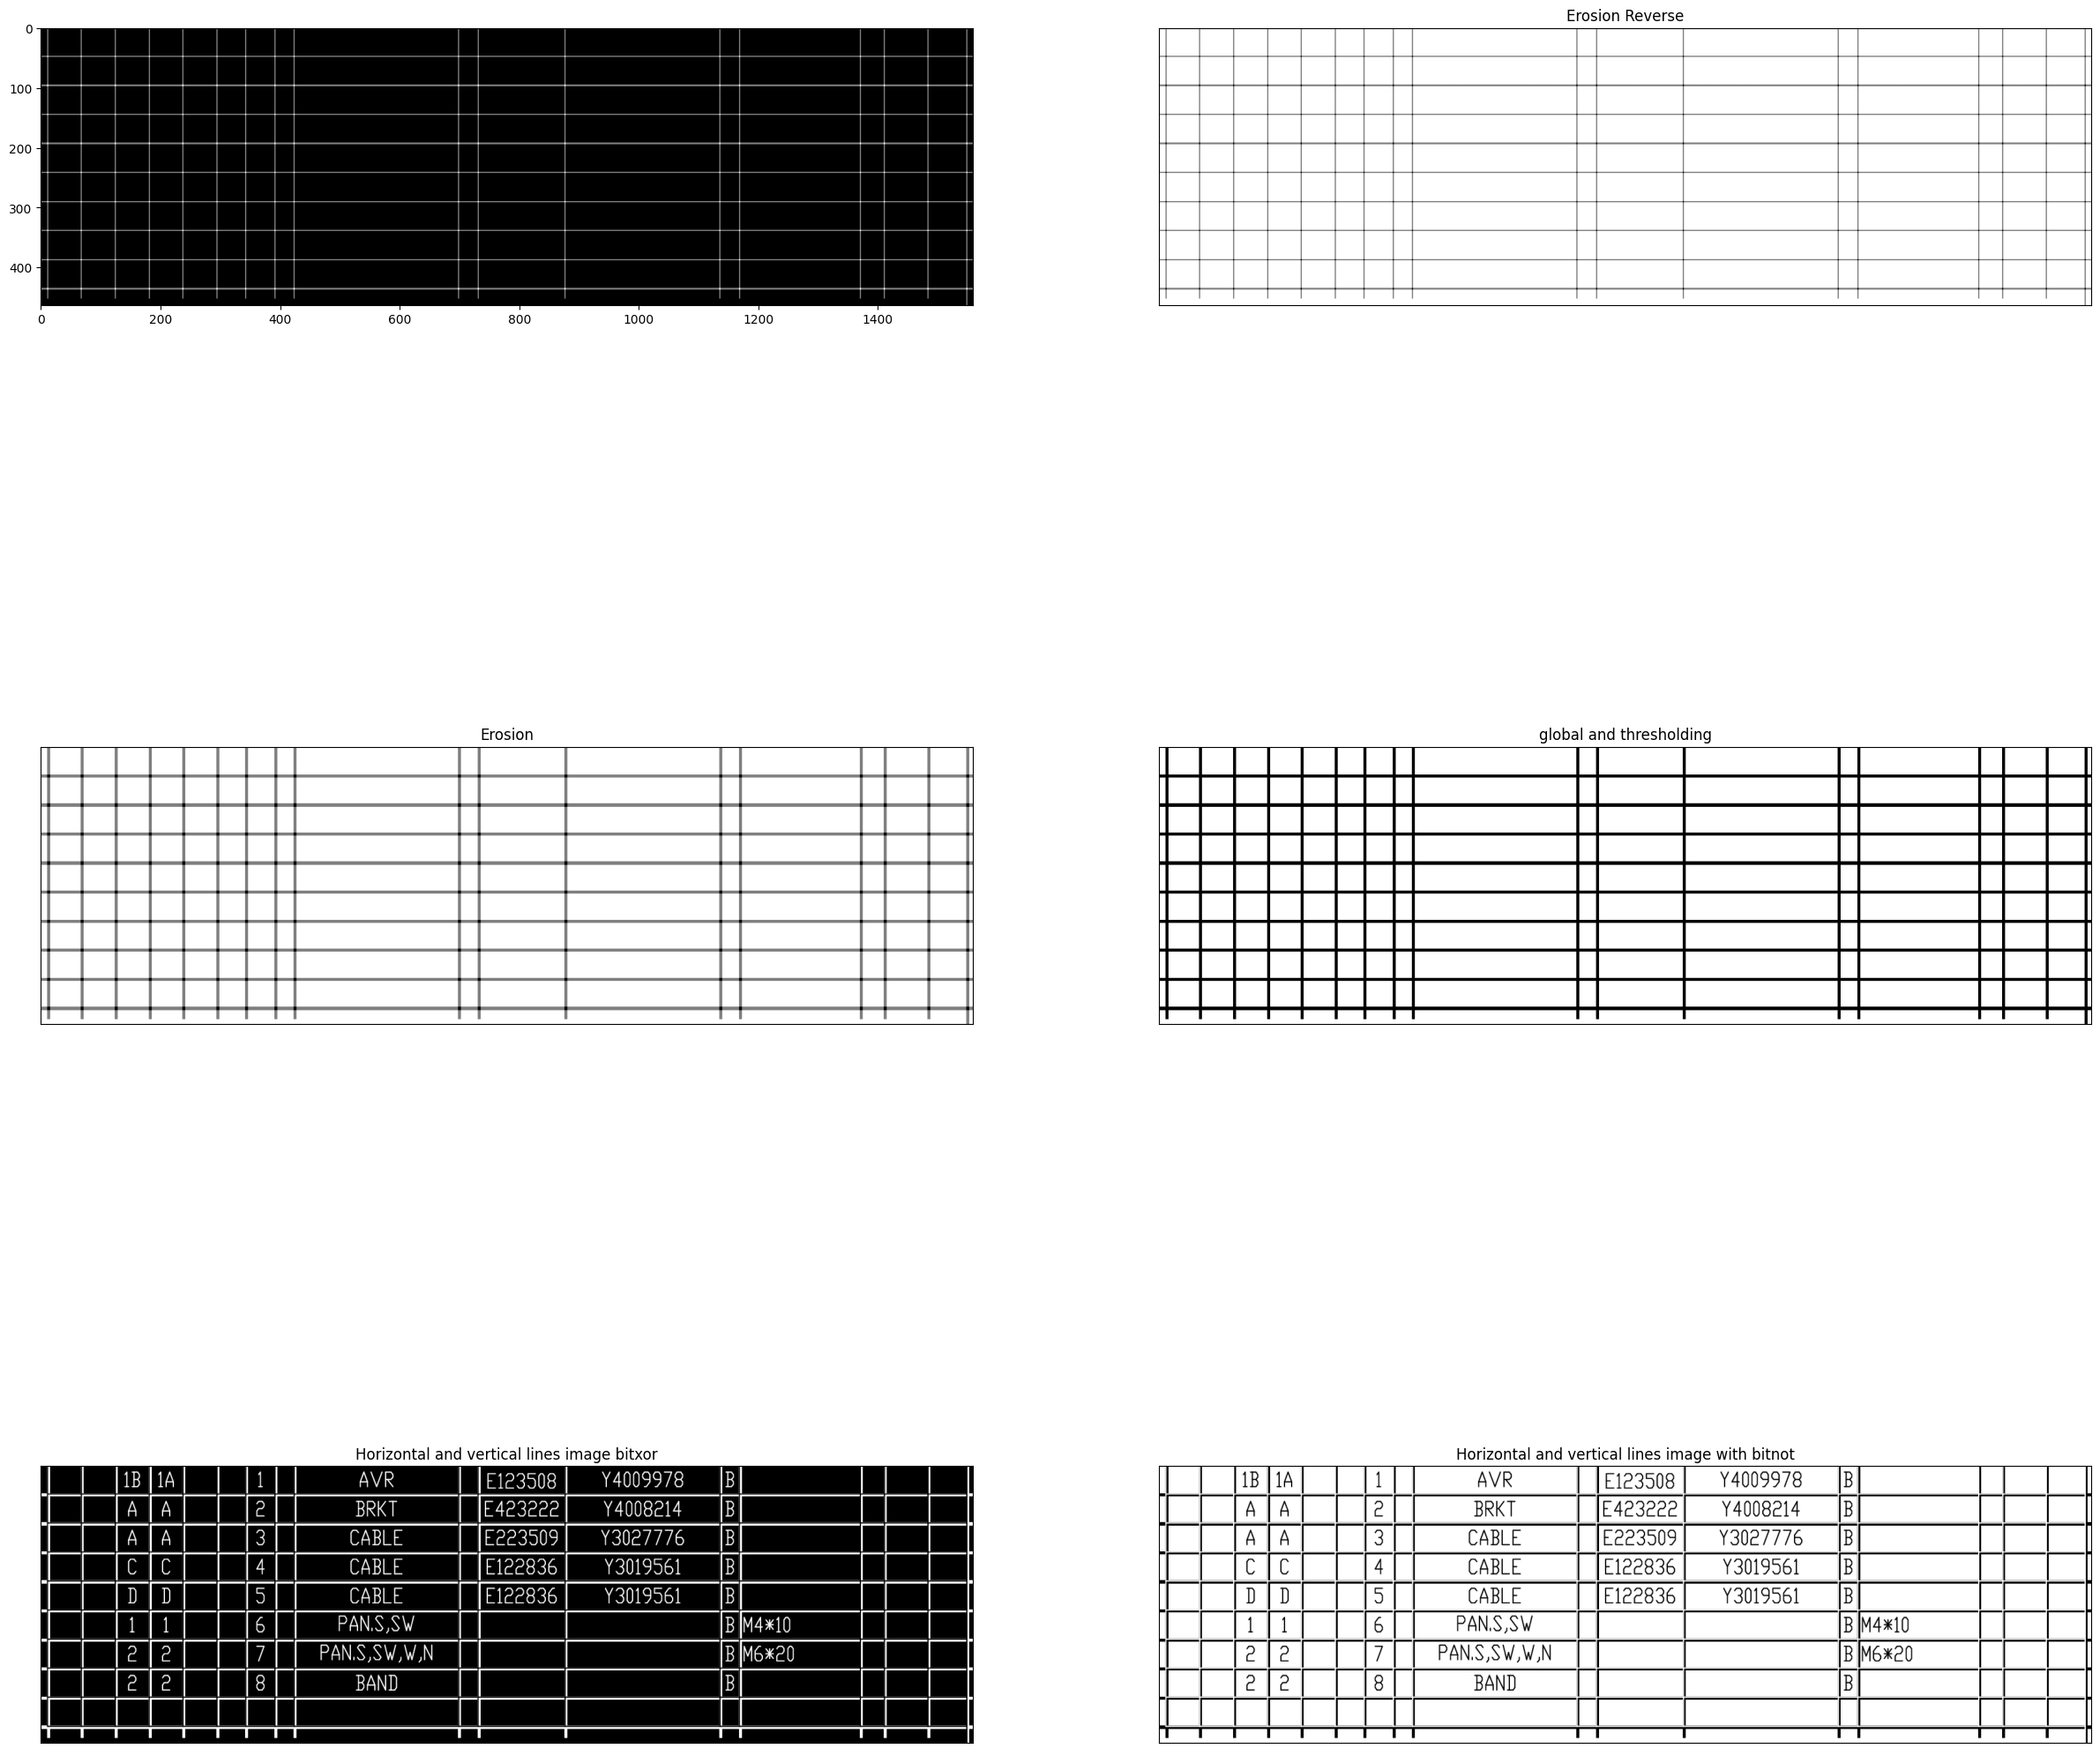

In [9]:
plt.figure(figsize=(30, 30))

# cv2.addWeighted() 合併2個值，可以加入權重
# 合併 "vertical_lines"和 "horizontal_lines"，權重皆為50%，第3個權重為添加到每個總和的標量
vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
plt.title('Vertical Horizontal AddWeighted'), plt.xticks([]), plt.yticks([])
plt.subplot(321), plt.imshow(cv2.cvtColor(vertical_horizontal_lines, cv2.COLOR_BGR2RGB))
# "~"語意是不等於
# 繪出vertical_horizontal_lines的倒置圖像(黑白相反)
plt.subplot(322), plt.imshow(cv2.cvtColor(~vertical_horizontal_lines, cv2.COLOR_BGR2RGB))
# plt.title('組合後的圖像倒置'), plt.xticks([]), plt.yticks([])
plt.title('Erosion Reverse'), plt.xticks([]), plt.yticks([])
# cv2.erode() 侵蝕遮罩，使用ver_hor_kernel作為遮罩，iterations=3 執行3次
# ver_hor_kernel在前面已完成，[[1,1],[1,1]]
# 將vertical_horizontal_lines倒置後侵蝕，並重新儲存
vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, ver_hor_kernel, iterations=3)
plt.subplot(323), plt.imshow(cv2.cvtColor(vertical_horizontal_lines, cv2.COLOR_BGR2RGB))
# plt.title('侵蝕後的圖像'), plt.xticks([]), plt.yticks([])
plt.title('Erosion'), plt.xticks([]), plt.yticks([])

# cv2.threshold() 將圖像二值化(黑或白)，二值化閾值可使用"BINARY" 或"OSTU"
thresh_ver_hor, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print('thresh_ver_hor= ', thresh_ver_hor)
plt.subplot(324), plt.imshow(cv2.cvtColor(vertical_horizontal_lines, cv2.COLOR_BGR2RGB))
# plt.title('顯示全域otsu二值化結果'), plt.xticks([]), plt.yticks([])
# plt.title('global and otsu thresholding'), plt.xticks([]), plt.yticks([])
# plt.title('顯示全域二值化結果'), plt.xticks([]), plt.yticks([])
plt.title('global and thresholding'), plt.xticks([]), plt.yticks([])
# cv2.bitwise_xor() 互斥或判定，若像素位置 "img 及 vertical_horizontal_lines"相同則輸出"0"，只符合其1則輸出"1"
bitxor = cv2.bitwise_xor(img, vertical_horizontal_lines)
plt.subplot(325), plt.imshow(cv2.cvtColor(bitxor, cv2.COLOR_BGR2RGB))
# plt.title('垂直及水平線合併後與img進行互斥或判斷的結果'), plt.xticks([]), plt.yticks([])
plt.title('Horizontal and vertical lines image bitxor'), plt.xticks([]), plt.yticks([])
# cv2.bitwise_not() 相反判定，若像素位置是 "img 及 vertical_horizontal_lines"則輸出"0"，不是則輸出"1"
bitnot = cv2.bitwise_not(bitxor)
plt.subplot(326), plt.imshow(cv2.cvtColor(bitnot, cv2.COLOR_BGR2RGB))
# plt.title('非互補圖像的結果'), plt.xticks([]), plt.yticks([])
plt.title('Horizontal and vertical lines image with bitnot'), plt.xticks([]), plt.yticks([])

plt.show()

In [10]:
# cv2.findContours() 尋找圖像中的輪廓點座標
# cv2.findContours() 函式返回兩個輸出引數。第一個輸出引數包含輪廓的位置點和列表中的座標，第二個輸出引數包含輪廓的層次結構
# cv2.findContours() 函式的第一個輸入是二進位制或灰度影象，第二個輸入引數是用於定義輪廓層次結構的檢索模式
# 有4種檢索模式，cv2.RETR_LIST, cv2.RETR_TREE, cv2.RETR_CCOMP, cv2.RETR_EXTERNAL
# cv2.RETR_LIST 獲取所有輪廓，不分層級
# cv2.RETR_TREE 獲取所有輪廓，區分層級
# cv2.RETR_EXTERNAL 只獲取最外層(父層)
# cv2.RETR_CCOMP 獲取所有輪廓，皆區分為第1層及第2層
# cv2.CHAIN_APPROX_SIMPLE 壓縮取回的Contour像素點，每段輪廓只取end points(三角形取3點、四邊形取4點)，而不傳回所有的點，可節省記憶體並加速運算
# cv2.CHAIN_APPROX_NONE 取回所有輪廓點，需大量記憶體空間
# contours 輪廓，hierarchy 層級
contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# print('coutourlens= \n', len(contours))
# print('coutours= \n', contours)
# print('hierarchy= \n', hierarchy)

In [11]:
# boundingBoxes 邊界框
boundingBoxes = []
# 從contours陣列中提取單一contour
for contour in contours:
    # cv2.boundingRect() 使用1個最小矩形擬合contour並紀錄為"x, y, w, h"後取出，存入boundingBoxes中
    # x,y是矩形的左上角點座標，w是矩形在x座標上的長度，h是矩形在y座標的長度
    # 將contour的4點座標轉換為"x, y, w, h"
    boundingBoxes.append(cv2.boundingRect(contour))
# 可將上述指令簡寫為下列單行內容
# boundingBoxes = [cv2.boundingRect(contour) for contour in contours]

print('boundingBoxlens= ', len(boundingBoxes))
print('boundingBoxes= \n', boundingBoxes)

boundingBoxlens=  173
boundingBoxes= 
 [(1553, 440, 6, 23), (0, 440, 1548, 23), (1553, 391, 6, 43), (1488, 391, 60, 43), (1415, 391, 68, 43), (1375, 391, 35, 43), (1173, 391, 197, 43), (1140, 391, 28, 43), (881, 391, 254, 43), (736, 391, 140, 43), (703, 391, 28, 43), (428, 391, 270, 43), (396, 391, 27, 43), (347, 391, 44, 43), (299, 391, 43, 43), (242, 391, 52, 43), (186, 391, 51, 43), (129, 391, 52, 43), (72, 391, 52, 43), (16, 391, 51, 43), (0, 391, 11, 43), (1553, 342, 6, 44), (1488, 342, 60, 44), (1415, 342, 68, 44), (1375, 342, 35, 44), (1173, 342, 197, 44), (1140, 342, 28, 44), (881, 342, 254, 44), (736, 342, 140, 44), (703, 342, 28, 44), (428, 342, 270, 44), (396, 342, 27, 44), (347, 342, 44, 44), (299, 342, 43, 44), (242, 342, 52, 44), (186, 342, 51, 44), (129, 342, 52, 44), (72, 342, 52, 44), (16, 342, 51, 44), (0, 342, 11, 44), (1553, 294, 6, 43), (1488, 294, 60, 43), (1415, 294, 68, 43), (1375, 294, 35, 43), (1173, 294, 197, 43), (1140, 294, 28, 43), (881, 294, 254, 43), (73

In [12]:
# 將contours與boundingBoxes鏈結
# zip() 可將不同變數做鏈結
# sorted 將list重原本的位置取出後重新排序，不影響原list內容，sorted前面的"*" 可以解除一階打包
# key=lambda x:x[1][1] 相同位置的任意值
(contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda x:x[1][1]))

# print('contourlens= ', len(contours))
# print('boundingBoxlens= ', len(boundingBoxes))
# print(contours, boundingBoxes)

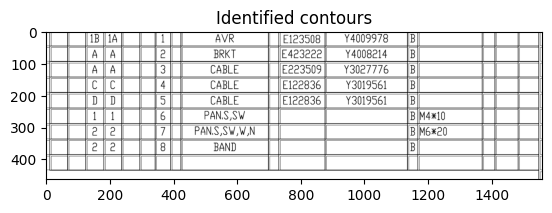

boxlens=  172
boxes=  [[1553, 0, 6, 46], [1488, 0, 60, 46], [1415, 0, 68, 46], [1375, 0, 35, 46], [1173, 0, 197, 46], [1140, 0, 28, 46], [881, 0, 254, 46], [736, 0, 140, 46], [703, 0, 28, 46], [428, 0, 270, 46], [396, 0, 27, 46], [347, 0, 44, 46], [299, 0, 43, 46], [242, 0, 52, 46], [186, 0, 51, 46], [129, 0, 52, 46], [72, 0, 52, 46], [16, 0, 51, 46], [0, 0, 11, 46], [1553, 51, 6, 43], [1488, 51, 60, 43], [1415, 51, 68, 43], [1375, 51, 35, 43], [1173, 51, 197, 43], [1140, 51, 28, 43], [881, 51, 254, 43], [736, 51, 140, 43], [703, 51, 28, 43], [428, 51, 270, 43], [396, 51, 27, 43], [347, 51, 44, 43], [299, 51, 43, 43], [242, 51, 52, 43], [186, 51, 51, 43], [129, 51, 52, 43], [72, 51, 52, 43], [16, 51, 51, 43], [0, 51, 11, 43], [1553, 100, 6, 43], [1488, 100, 60, 43], [1415, 100, 68, 43], [1375, 100, 35, 43], [1173, 100, 197, 43], [1140, 100, 28, 43], [881, 100, 254, 43], [736, 100, 140, 43], [703, 100, 28, 43], [428, 100, 270, 43], [396, 100, 27, 43], [347, 100, 44, 43], [299, 100, 43, 

In [13]:
# 提取表格中每個單元格的邊界框，並記錄邊界框的"x, y, w, h"
# x,y是矩形的左上角點座標，w是矩形在x座標上的長度，h是矩形在y座標的長度
# 建立boxes矩陣來儲存邊界框的"x, y, w, h"
boxes = []
# 從contours矩陣中提取單一contour
for contour in contours:
    # cv2.boundingRect() 使用1個最小矩形擬合contour並紀錄為"x, y, w, h"後取出，存入boundingBoxes中
    # x,y是矩形的左上角點座標，w是矩形在x座標上的長度，h是矩形在y座標的長度
    x, y, w, h = cv2.boundingRect(contour)
    # 如果在w<1000和h<500的範圍
    if (w<1000 and h<500):
        # cv2.rectangle() 繪出矩形，矩形會畫在img上，矩形左上角座標點"x,y"，矩形右下角座標點"x+w,y+h"，"0,255,0"矩形顏色，"3"矩形框線粗細
        img_boxes = cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 1)
        # 將"x, y, w, h"以指定格是存入boxes
        boxes.append([x, y, w, h])

plotting = plt.imshow(cv2.cvtColor(img_boxes, cv2.COLOR_BGR2RGB))
# plt.title('符合尺寸的輪廓')
plt.title('Identified contours')
plt.show()

print('boxlens= ', len(boxes))
print('boxes= ', boxes)

要存儲行和列：先將行和列的列表初始化為空list。
計算所有框的平均高度。
最初，第一個框被附加到列列表中。
列的列表本質上是一個臨時列表。
前一個框也分配給第一個框。
循環遍歷剩餘的boundingBoxes列表。
在每次迭代中，檢查當前框左上角的 y 坐標是否小於前一個框的 y 坐標加上所有高度平均值的一半。

如果是：當前框附加到列的列表中。
* 當前框分配給前一個框。
* 接下來檢查我們是否在最後一個索引處。
* 如果是：整列附加到行列表。

如果不：列的列表附加到行。
* 列的列表被分配為空，因為這將啟動一個新的空列的列表。
* 當前框分配給前一個框變量。
* 當前框被附加到我們剛剛創建的空列的列表中

In [14]:
# rows 行
# 記錄圖像中獲取的所有表格的boxes座標
rows = []
# columns 列
# 記錄rows其中某一行所有boxes座標
columns = []
# heights 高
heights = []
# 從len(boundingBoxes)提出第i項
for i in range(len(boundingBoxes)):
    # 將boundingBoxes第i項的"3"號位提取並存入heights
    # 在程式邏輯中位置從0開始，0、1、2、3，3號位實際上為第4個值
    heights.append(boundingBoxes[i][3])
# 可將上述指令簡寫為下列單行內容
# heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
# print('heights= ', heights)

# np.mean() 取平均值，將heights做平均計算
mean = np.mean(heights)
print('mean= ', mean)

columns.append(boxes[0])
# previous 之前的
# 將previous指定為boxes的"0"號位內容
previous = boxes[0]

# 從len(1, len(boxes))提出第"i"項
for i in range(1, len(boxes)):
    # 如果第"i"項的"1"號位內容 <= "previous"1"號位的內容" + "heights平均值的一半"
    # "1"號位是"y"
    if(boxes[i][1] <= previous[1]+mean/2):
        # 將boxes第"i"項加入columns
        columns.append(boxes[i])
        # print('columnlens= ', len(columns))
        # 將第"i"項帶入previous
        previous = boxes[i]
        # 如果"i"的值是len(boxes)-1
        if(i == len(boxes)-1):
            # 將columns加入rows
            rows.append(columns)
    # 如果不是上述判斷
    else:
        # 將columns加入rows
        rows.append(columns)
        # 將columns清空
        columns = []
        # 將第"i"項帶入previous
        previous = boxes[i]
        # 將boxes第"i"項加入columns
        columns.append(boxes[i])
        # print('columnlens= ', len(columns))
print('rowlens= ', len(rows))
# for i in range(len(rows)):
    # print('row[',i,']lens= ', len(rows[i]))

print("ROWS")
# 從rows矩陣中提取單一row
for row in rows:
    print(row)

mean=  43.31791907514451
rowlens=  9
ROWS
[[1553, 0, 6, 46], [1488, 0, 60, 46], [1415, 0, 68, 46], [1375, 0, 35, 46], [1173, 0, 197, 46], [1140, 0, 28, 46], [881, 0, 254, 46], [736, 0, 140, 46], [703, 0, 28, 46], [428, 0, 270, 46], [396, 0, 27, 46], [347, 0, 44, 46], [299, 0, 43, 46], [242, 0, 52, 46], [186, 0, 51, 46], [129, 0, 52, 46], [72, 0, 52, 46], [16, 0, 51, 46], [0, 0, 11, 46]]
[[1553, 51, 6, 43], [1488, 51, 60, 43], [1415, 51, 68, 43], [1375, 51, 35, 43], [1173, 51, 197, 43], [1140, 51, 28, 43], [881, 51, 254, 43], [736, 51, 140, 43], [703, 51, 28, 43], [428, 51, 270, 43], [396, 51, 27, 43], [347, 51, 44, 43], [299, 51, 43, 43], [242, 51, 52, 43], [186, 51, 51, 43], [129, 51, 52, 43], [72, 51, 52, 43], [16, 51, 51, 43], [0, 51, 11, 43]]
[[1553, 100, 6, 43], [1488, 100, 60, 43], [1415, 100, 68, 43], [1375, 100, 35, 43], [1173, 100, 197, 43], [1140, 100, 28, 43], [881, 100, 254, 43], [736, 100, 140, 43], [703, 100, 28, 43], [428, 100, 270, 43], [396, 100, 27, 43], [347, 100, 44

In [15]:
# python數學統計函式
# import statistics

# 將lens(rows[i])建立為list
rowslens = []
for i in range(len(rows)):
    rowslens.append(len(rows[i]))
print('rowslens= ', rowslens)
# statistics.mode() 可用來尋找list中的眾數
count = statistics.mode(rowslens)
print('count= ', count)

# total_cells
# 指定total_cells為0
# total_cells = 0
# 指定total_cells為rows[i]的眾數
total_cells = count
print('total_cells= ', total_cells)

rowslens=  [19, 19, 19, 19, 19, 19, 19, 19, 19]
count=  19
total_cells=  19


In [16]:
# center 中心
# center 用來儲存rows中x軸各rows的中心點
center = []
# 從len(rows)"0"號位(列1)提出第"j"項(行)
# len(rows)"0"號位是圖像的第1列表格的boxes值
# for j in range(len(rows[0])):
# 強迫center的數量已rows[i]決定而非rows[0]
for j in range(len(rows[i])):
    # 如果是rows的"0"號位
    # if rows[0]:
    if rows[i]:
        # 從rows"0"號位(列1)的第"j"號位(行j)提取"0"號位(x)+"0"號位(列1)的第"j"號位(行j)提取"2"號位(w)/2，再以"int(整數)"格式存入center
        # center.append(int(rows[0][j][0]+rows[0][j][2]/2))
        center.append(int(rows[i][j][0]+rows[i][j][2]/2))
# 可將上述指令簡寫為下列單行內容
# center = [int(rows[i][j][0]+rows[i][j][2]/2) for j in range(len(rows[i])) if rows[0]]

print('centerlens= ', len(center))
print('center= ', center)

centerlens=  19
center=  [1556, 1518, 1449, 1392, 1271, 1154, 1008, 806, 717, 563, 409, 369, 320, 268, 211, 155, 98, 41, 5]


In [17]:
# 將center改為陣列
# np.array() 建立陣列
center = np.array(center)

# 將center由小到大重新排列
center.sort()
print('centerlens= ', len(center))
print('center= ', center)

centerlens=  19
center=  [   5   41   98  155  211  268  320  369  409  563  717  806 1008 1154
 1271 1392 1449 1518 1556]


In [18]:
# boxes_list 記錄圖像內所有表格重新排序後的座標
boxes_list = []
for i in range(len(rows)):
    # l 空矩陣
    l = []
    # 從total_cells提出第"k"項
    for k in range(total_cells):
        # 將與total_cells同等數量的空矩陣加入l中
        l.append([])
    # 從len(rows[i])提出第"j"項
    for j in range(len(rows[i])):
        # diff 取各個rows中心點往rows的x座標一半的長度
        # abs() 取絕對值
        # 取center-(rows第"i"項(列i)的第"j"項(行j)的"0"號位(x)+第"i"項(列i)的第"j"項(行j)的"2"號位(w)/4)
        diff = abs(center-(rows[i][j][0]+rows[i][j][2]/4))
        # print('difflens= ', len(diff))
        # print('diff= ', diff)
        # minimum 從各個diff中找最小值
        # min() 取最小值
        minimum = min(diff)
        # print('minimum= ', minimum)
        # indexing 紀錄diff中最小值的位置
        # list().index() 索引，在範圍內搜尋需要的資料
        indexing = list(diff).index(minimum)
        # print('indexing= ', indexing)
        # 將rows第"i"項(列i)的第"j"項(行j)加入l[indexing]的位置
        l[indexing].append(rows[i][j])
        # print("l =", l)
    # 將l[indexing]存入boxes_list
    boxes_list.append(l)
    
# 從boxes_list矩陣中提取單一box
for box in boxes_list:
    print('box= ', box)

box=  [[[0, 0, 11, 46]], [[16, 0, 51, 46]], [[72, 0, 52, 46]], [[129, 0, 52, 46]], [[186, 0, 51, 46]], [[242, 0, 52, 46]], [[299, 0, 43, 46]], [[347, 0, 44, 46]], [[396, 0, 27, 46]], [[428, 0, 270, 46]], [[703, 0, 28, 46]], [[736, 0, 140, 46]], [[881, 0, 254, 46]], [[1140, 0, 28, 46]], [[1173, 0, 197, 46]], [[1375, 0, 35, 46]], [[1415, 0, 68, 46]], [[1488, 0, 60, 46]], [[1553, 0, 6, 46]]]
box=  [[[0, 51, 11, 43]], [[16, 51, 51, 43]], [[72, 51, 52, 43]], [[129, 51, 52, 43]], [[186, 51, 51, 43]], [[242, 51, 52, 43]], [[299, 51, 43, 43]], [[347, 51, 44, 43]], [[396, 51, 27, 43]], [[428, 51, 270, 43]], [[703, 51, 28, 43]], [[736, 51, 140, 43]], [[881, 51, 254, 43]], [[1140, 51, 28, 43]], [[1173, 51, 197, 43]], [[1375, 51, 35, 43]], [[1415, 51, 68, 43]], [[1488, 51, 60, 43]], [[1553, 51, 6, 43]]]
box=  [[[0, 100, 11, 43]], [[16, 100, 51, 43]], [[72, 100, 52, 43]], [[129, 100, 52, 43]], [[186, 100, 51, 43]], [[242, 100, 52, 43]], [[299, 100, 43, 43]], [[347, 100, 44, 43]], [[396, 100, 27, 43

boxes_list_rectangle= 
 [[0, 0, 11, 46], [16, 0, 67, 46], [72, 0, 124, 46], [129, 0, 181, 46], [186, 0, 237, 46], [242, 0, 294, 46], [299, 0, 342, 46], [347, 0, 391, 46], [396, 0, 423, 46], [428, 0, 698, 46], [703, 0, 731, 46], [736, 0, 876, 46], [881, 0, 1135, 46], [1140, 0, 1168, 46], [1173, 0, 1370, 46], [1375, 0, 1410, 46], [1415, 0, 1483, 46], [1488, 0, 1548, 46], [1553, 0, 1559, 46], [0, 51, 11, 94], [16, 51, 67, 94], [72, 51, 124, 94], [129, 51, 181, 94], [186, 51, 237, 94], [242, 51, 294, 94], [299, 51, 342, 94], [347, 51, 391, 94], [396, 51, 423, 94], [428, 51, 698, 94], [703, 51, 731, 94], [736, 51, 876, 94], [881, 51, 1135, 94], [1140, 51, 1168, 94], [1173, 51, 1370, 94], [1375, 51, 1410, 94], [1415, 51, 1483, 94], [1488, 51, 1548, 94], [1553, 51, 1559, 94], [0, 100, 11, 143], [16, 100, 67, 143], [72, 100, 124, 143], [129, 100, 181, 143], [186, 100, 237, 143], [242, 100, 294, 143], [299, 100, 342, 143], [347, 100, 391, 143], [396, 100, 423, 143], [428, 100, 698, 143], [703, 

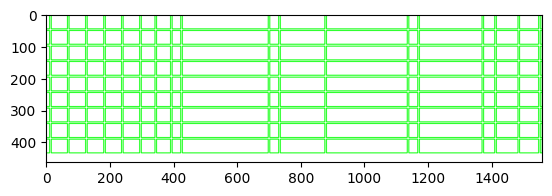

In [19]:
# 從len(boxes_list第"i"項(列i)的第"j"項(行j))中提取第"k"項
blank_img_list = []
for i in range(len(boxes_list)):
    for j in range(len(boxes_list[i])):
        for k in range(len(boxes_list[i][j])):
            # 將boxes_list的"x, y, w, h"分別提出存取
            y, x, w, h = boxes_list[i][j][k][0], boxes_list[i][j][k][1], boxes_list[i][j][k][2], boxes_list[i][j][k][3]
            # print(y, x, w, h)
            blank_img_list.append([y,x,y+w,x+h])
print('boxes_list_rectangle= \n', blank_img_list)
for i in range(len(blank_img_list)):
    for j in range(len(blank_img_list[i])):
        # cv2.rectangle() 畫出矩形
        # 在空白圖像上以矩形畫出從boxes_list取出的"x, y, w, h"範圍
        blank_img_dataframe = cv2.rectangle(blank_img, (int(blank_img_list[i][0]),int(blank_img_list[i][1])), (int(blank_img_list[i][2]),int(blank_img_list[i][3])), (0,255,0), 2)
# 顯示框出矩形範圍後的圖像
blank_img_dataframe_plot = plt.imshow(cv2.cvtColor(blank_img_dataframe, cv2.COLOR_BGR2RGB))

In [20]:
import pytesseract
from pytesseract import Output
from PIL import Image


# 重新訓練tessercat-ocr的tessdata，提高圖像中文字辨識度
# eng_1_config = r'--tessdata-dir "D:\Study\Code" -l eng_1_0305'
eng_1_config = r'-l eng_1_0305'

使用 Pytesseract 從圖像中的單元格中提取文本
* 從圖像中提取感興趣區域（ROI）。
* 調整單元格大小，然後對提取的單元格區域進行形態學操作以去除噪點。
* 最後使用pytesseract將圖像轉換為字符串。
* 字符串首先附加到每一行到帶有空格的臨時字符串 s，然後我們將此臨時字符串附加到最終數據幀。

dataframe_final_lens=  171
dataframe_final= 
 ['', '', '', '', '', '', '', '', '', 'AVR\n', '', 'E123508\n', 'Y4009978\n', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'BRKT\n', '', 'E4232ee\n', 'Y4008214\n', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'CABLE\n', '', 'E22e3309\n', 'Y3027776\n', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'CABLE\n', '', 'E1e2836\n', 'Y3019561\n', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'CABLE\n', '', 'Ele2836\n', 'Y3019561\n', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'PAN.S,SW\n', '', '', '', '', 'M4x10\n', '', '', '', '', '', '', '', '', '', '', '', '', '', 'PAN.S,SW,W,N\n', '', '', '', '', 'M6x20\n', '', '', '', '', '', '', '', '', '', '', '', '', '', 'BAND\n', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


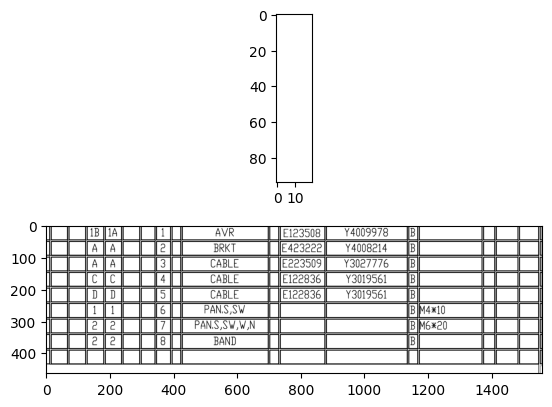

In [21]:
# dataframe_final 記錄OCR讀取的內容
dataframe_final = []
# 紀錄y, x, w, h對角座標值，後續用來繪製檢測區塊
img_list = []
# 從len(boxes_list)中提取第"i"項
for i in range(len(boxes_list)):
    for j in range(len(boxes_list[i])):
        # s 空白字元
        # s = ' '
        s = ''
        # 如果boxes_list第"i"項(列i)的第"j"項(行j) = 0
        if(len(boxes_list[i][j])==0):
            print('boxes_list[i][j]= ', boxes_list[i][j])
            dataframe_final.append(' ')
        else:
            # 從len(boxes_list第"i"項(列i)的第"j"項(行j))中提取第"k"項
            for k in range(len(boxes_list[i][j])):
                # 將boxes_list的"x, y, w, h"分別提出存取
                y, x, w, h = boxes_list[i][j][k][0], boxes_list[i][j][k][1], boxes_list[i][j][k][2], boxes_list[i][j][k][3]
                # 將y, x, w, h以cv2.rectangle所需的座標值重新儲存在img_list中
                img_list.append([y,x,y+w,x+h])
                # roi 從bitnot中提取"x, y, w, h"範圍的像素內容
                roi = bitnot[x:x+h, y:y+w]
                # roi = vertical_horizontal_lines[x:x+h, y:y+w]
                # print('roi= ', roi)
                # cv2.getStructuringElement() 建立結構矩陣，矩陣(2,1)內每個值皆為1
                # kernel_ocr = cv2.getStructuringElement(cv2.MORPH_RECT, (2,1))
                # 變更遮罩尺寸
                kernel_ocr = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
                # print('kernel= \n', kernel_ocr)
                # border 邊界
                # cv2.copyMakeBorder() 在roi像素範圍外建立邊框，上下左右寬度=2，邊框位置以顏色填滿，顏色為白色
                border = cv2.copyMakeBorder(roi, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255,255])
                # border = cv2.copyMakeBorder(roi, 3, 3, 3, 3, cv2.BORDER_CONSTANT, value=[255,255])
                # resizing 調整大小
                # cv2.resize() 調整圖像，"fx=2, fy=2"圖像x,y放大2倍，"interpolation=cv2.INTER_CUBIC"放大方式 4x4像素鄰域的雙三次插值
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                # resizing = cv2.resize(border, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
                # cv2.dilate() 膨脹
                dilation = cv2.dilate(resizing, kernel_ocr, iterations=1)
                # cv2.erode() 侵蝕
                erosion = cv2.erode(dilation, kernel_ocr, iterations=2)
                # erosion = cv2.erode(dilation, kernel_ocr, iterations=1)
                out_plot = plt.subplot(211), plt.imshow(cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB))
                # out_plot = plt.subplot(211), plt.imshow(cv2.cvtColor(resizing, cv2.COLOR_BGR2RGB))
                # pytesseract.image_to_string() 從圖像中辨識文字
                out = pytesseract.image_to_string(erosion)
                # out = pytesseract.image_to_string(resizing)
                # 使用自訓練集做文字辨識
                # out = pytesseract.image_to_string(erosion, config=eng_1_config)
                # 如果len(out)=0
                if(len(out)==0):
                    # 再做一次文字辨識
                    out = pytesseract.image_to_string(erosion)
                    # out = pytesseract.image_to_string(resizing)
                    # out = pytesseract.image_to_string(erosion, config=eng_1_config)
                # s = s + 空白 + out
                # 每個輸出之間都以空白隔開
                # s = s + ' ' + out
                s = s + out
            # 將s加入dataframe_final
            dataframe_final.append(s)

# cv2.rectangle() 畫出矩形
# 在圖像上以矩形畫出從boxes_list取出的"x, y, w, h"範圍
for i in range(len(img_list)):
    for j in range(len(img_list[i])):
        img_dataframe = cv2.rectangle(img, (int(img_list[i][0]),int(img_list[i][1])), (int(img_list[i][2]),int(img_list[i][3])), (0,255,0), 2)
# 顯示框出矩形範圍後的圖像
img_dataframe_plot = plt.subplot(212), plt.imshow(cv2.cvtColor(img_dataframe, cv2.COLOR_BGR2RGB))
# 列出dataframe_final
print('dataframe_final_lens= ', len(dataframe_final))
print('dataframe_final= \n', dataframe_final)

In [22]:
# 使用Regular Expression的re.sub修改常見的錯誤字元
# import re

# list及np.array內容中的單獨字元不可直接修改，只能讀出或填入，若需修改內容的字元需先轉為str格式

str_dataframe_final = []
for i in dataframe_final:
    str_i = str(i)# re.sub(pattern, repl, string, count=0, flags=0) 將指定內容作替換，
    # pattern替換前的內容，repl是替換後的內容，string是愈替換的變數，count是要替換的數量(0預設為全部替換)，flags如果沒找到回傳none
    str_i = re.sub('^ |\n', '', str_i, count=0, flags=0)
    str_i = re.sub('l', '1', str_i, count=0, flags=0)
    str_i = re.sub('e', '2', str_i, count=0, flags=0)
    str_i = re.sub('~', '7', str_i, count=0, flags=0)
    str_i = re.sub('^F2', 'E2', str_i, count=0, flags=0)
    str_i = re.sub('^EcA|^ECA', 'E2A', str_i, count=0, flags=0)
    str_i = re.sub('^E2AL', 'E2A1', str_i, count=0, flags=0)
    str_i = re.sub('^E2AC|^E2AC', 'E2A2', str_i, count=0, flags=0)
    str_i = re.sub('^Y |^¥', 'Y', str_i, count=0, flags=0)
    str_i = re.sub('\$$|<', 'S', str_i, count=0, flags=0)
    str_i = re.sub('SS$', 'S', str_i, count=0, flags=0)
    str_i = re.sub('CA$|cA$', '2A', str_i, count=0, flags=0)
    str_i = re.sub('2/S$', '27S', str_i, count=0, flags=0)
    str_i = re.sub('-T', '-1', str_i, count=0, flags=0)
    str_i = re.sub('.21$', '.2T', str_i, count=0, flags=0)
    str_i = re.sub('.51$', '.5T', str_i, count=0, flags=0)
    str_i = re.sub('X\*|%\*', '*', str_i, count=0, flags=0)
    str_i = re.sub(',$|\?', '.', str_i, count=0, flags=0)
    str_i = re.sub('\.$', '', str_i, count=0, flags=0)
    str_i = re.sub('H-.2T$', 'H-1.2T', str_i, count=0, flags=0)
    str_i = re.sub('H-.5T$', 'H-1.5T', str_i, count=0, flags=0)
    str_i = re.sub('-L6T$|-1L6T$|-LO6T$', '-1.6T', str_i, count=0, flags=0)
    str_i = re.sub('CUVER$', 'COVER', str_i, count=0, flags=0)
    str_i = re.sub('^ ', '', str_i, count=0, flags=0)
    str_i = re.sub('0 ', '0', str_i, count=0, flags=0)
    str_i = re.sub('1 ', '1', str_i, count=0, flags=0)
    str_i = re.sub('2 ', '2', str_i, count=0, flags=0)
    str_i = re.sub('3 ', '3', str_i, count=0, flags=0)
    str_i = re.sub('4 ', '4', str_i, count=0, flags=0)
    str_i = re.sub('5 ', '5', str_i, count=0, flags=0)
    str_i = re.sub('6 ', '6', str_i, count=0, flags=0)
    str_i = re.sub('7 ', '7', str_i, count=0, flags=0)
    str_i = re.sub('8 ', '8', str_i, count=0, flags=0)
    str_i = re.sub('9 ', '9', str_i, count=0, flags=0)
    str_i = re.sub('0\,', '0.', str_i, count=0, flags=0)
    str_i = re.sub('1\,', '1.', str_i, count=0, flags=0)
    str_i = re.sub('2\,', '2.', str_i, count=0, flags=0)
    str_i = re.sub('3\,', '3.', str_i, count=0, flags=0)
    str_i = re.sub('4\,', '4.', str_i, count=0, flags=0)
    str_i = re.sub('5\,', '5.', str_i, count=0, flags=0)
    str_i = re.sub('6\,', '6.', str_i, count=0, flags=0)
    str_i = re.sub('7\,', '7.', str_i, count=0, flags=0)
    str_i = re.sub('8\,', '8.', str_i, count=0, flags=0)
    str_i = re.sub('9\,', '9.', str_i, count=0, flags=0)
    str_dataframe_final.append(str_i)
print('str_dataframe_final_lens= ', len(str_dataframe_final))
str_dataframe_final

str_dataframe_final_lens=  171


['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'AVR',
 '',
 'E123508',
 'Y4009978',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'BRKT',
 '',
 'E423222',
 'Y4008214',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'CABLE',
 '',
 'E2223309',
 'Y3027776',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'CABLE',
 '',
 'E122836',
 'Y3019561',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'CABLE',
 '',
 'E122836',
 'Y3019561',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'PAN.S,SW',
 '',
 '',
 '',
 '',
 'M4x10',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'PAN.S,SW,W,N',
 '',
 '',
 '',
 '',
 'M6x20',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'BAND',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [23]:
# arr 陣列，將dataframe_final改為陣列
# np.array() 建立陣列
# arr = np.array(dataframe_final)
arr = np.array(str_dataframe_final)
arr

# np.char.upper()將所有字元轉為大寫
arr = np.char.upper(arr)
arr

array(['', '', '', '', '', '', '', '', '', 'AVR', '', 'E123508',
       'Y4009978', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', 'BRKT', '', 'E423222', 'Y4008214', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', 'CABLE', '', 'E2223309',
       'Y3027776', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', 'CABLE', '', 'E122836', 'Y3019561', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', 'CABLE', '', 'E122836', 'Y3019561',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       'PAN.S,SW', '', '', '', '', 'M4X10', '', '', '', '', '', '', '',
       '', '', '', '', '', '', 'PAN.S,SW,W,N', '', '', '', '', 'M6X20',
       '', '', '', '', '', '', '', '', '', '', '', '', '', 'BAND', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', ''], dtype='<U12')

從數組創建數據框
* 該數組被重塑為具有行數和列數的數據框
* 打印列並檢查

In [24]:
# import pandas as pd

# pd.DataFrame() 建立DataFrame(表格矩陣)
# arr.reshape() 指定陣列尺寸
dataframe = pd.DataFrame(arr.reshape(len(rows), total_cells))
print('rowslens= ', len(rows))
print('total_cells= ', total_cells)
print('dataframe= \n', dataframe)
print('dataframe_type= ', type(dataframe))
# style.set_properties(align='left')是pandas將表格內容靠左的功能
# data 紀錄dataframe靠左顯示的結果
data = dataframe.style.set_properties(align='left')
print('data= ', data)

# d = []
# for i in range(0,len(rows)):
#     for j in range(0,total_cells):
#         print(dataframe[i][j], end=' ')
#     print()

rowslens=  9
total_cells=  19
dataframe= 
   0  1  2  3  4  5  6  7  8             9  10        11        12 13     14  \
0                                      AVR      E123508  Y4009978             
1                                     BRKT      E423222  Y4008214             
2                                    CABLE     E2223309  Y3027776             
3                                    CABLE      E122836  Y3019561             
4                                    CABLE      E122836  Y3019561             
5                                 PAN.S,SW                            M4X10   
6                             PAN.S,SW,W,N                            M6X20   
7                                     BAND                                    
8                                                                             

  15 16 17 18  
0              
1              
2              
3              
4              
5              
6              
7              
8              
datafr

In [25]:
dataframe

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,,,,,,,AVR,,E123508,Y4009978,,,,,,
1,,,,,,,,,,BRKT,,E423222,Y4008214,,,,,,
2,,,,,,,,,,CABLE,,E2223309,Y3027776,,,,,,
3,,,,,,,,,,CABLE,,E122836,Y3019561,,,,,,
4,,,,,,,,,,CABLE,,E122836,Y3019561,,,,,,
5,,,,,,,,,,"PAN.S,SW",,,,,M4X10,,,,
6,,,,,,,,,,"PAN.S,SW,W,N",,,,,M6X20,,,,
7,,,,,,,,,,BAND,,,,,,,,,
8,,,,,,,,,,,,,,,,,,,


In [26]:
# 最後將這些數據保存為 csv 格式以供進一步使用
# 在google colab中生成了一個output.csv文件，可以下載

# dataframe.to_csv('output_table.csv')
# 將dataframe中的內容以讀入"最初圖像的檔名"存為csv檔
filename_csv = filename + '.csv'
dataframe.to_csv(filename_csv)